In [110]:
import numpy as np

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import seml.database as db_utils
from pathlib import Path

import torch

from itertools import product

from statsmodels.stats.proportion import proportion_confint

import pandas as pd

import os

import sys
sys.path.append('..')
from utils import load_results

In [111]:
collection = 'invariance_eval_forward_parallel'


jk_config = {
    'username': 'schuchaj',
    'password': 'coolpassword',
    'host': 'hostofyourdatabase',
    'port': 27017,
    'db_name': 'nameofyourdatabase'
}

col = db_utils.get_collection(collection, mongodb_config=jk_config)

In [112]:
def get_experiments(col, restrictions={}):
    
    restrictions['status'] = 'COMPLETED'

    if col.count_documents(restrictions) == 0:
        raise ValueError('No matches!')

    exps = col.find(restrictions, {'config':1, 'result': 1})
    
    return exps

In [113]:
def get_certificates(raw_results_file):
    raw_results = torch.load(raw_results_file)
    
    deltas = list(raw_results.keys())

    certified_accuracies = {
        'baseline': [],
        'preprocessing': [],
        'tight': []
    }

    certified_ratios = {
        'baseline': [],
        'preprocessing': [],
        'tight': []
    }

    for delta in deltas:
        correct_preds =[]
        abstains = []
        pcerts_baseline = []
        pcerts_preprocessing = []
        pcerts_tight = []

        for idx in raw_results[delta].keys():
            correct_preds.append(raw_results[delta][idx]['correct'])
            abstains.append(raw_results[delta][idx]['abstain'])
            pcerts_baseline.append(raw_results[delta][idx]['p_certs_baseline'][0])
            pcerts_preprocessing.append(raw_results[delta][idx]['p_certs_preprocessing'][0])

            tight = raw_results[delta][idx]['p_certs_tight'][0]
            if isinstance(tight, float):
                tight = np.array(3 * [tight])
            pcerts_tight.append(tight)
        
        correct_preds = np.array(correct_preds)
        abstains = np.array(abstains)
        certs_baseline = np.array(pcerts_baseline) > 0.5
        certs_preprocessing = np.array(pcerts_preprocessing) > 0.5
        certs_tight = np.array(pcerts_tight) > 0.5

        if delta == 0:
            certs_baseline[:] = True
            certs_preprocessing[:] = True
            certs_tight[:] = True

        certified_accuracies['baseline'].append((correct_preds & ~abstains & certs_baseline).mean())
        certified_accuracies['preprocessing'].append((correct_preds & ~abstains & certs_preprocessing).mean())
        certified_accuracies['tight'].append((correct_preds[:, None] & ~abstains[:, None] & certs_tight).mean(axis=0))

        certified_ratios['baseline'].append((certs_baseline).mean())
        certified_ratios['preprocessing'].append((certs_preprocessing).mean())
        certified_ratios['tight'].append((certs_tight).mean(axis=0))


    return deltas, certified_accuracies, certified_ratios

In [114]:
def generate_exp_result_dict(exp):

    result_dict = {}
    
    result_dict['std'] = exp['config']['std']
    result_dict['preprocess_translation'] = exp['config']['certificate_params']['preprocess_translation']
    
    result_dict['raw_results_file'] = exp['result']['save_file']

    deltas, certified_accuracies, certified_ratios = get_certificates(result_dict['raw_results_file'])

    result_dict['deltas'] = deltas
    result_dict['certified_accuracies_dict'] = certified_accuracies
    result_dict['certified_ratios_dict'] = certified_ratios


    return result_dict

In [115]:
experiments = get_experiments(col)

results = load_results(
            generate_exp_result_dict,
            experiments,
            results_file='/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/mnist_parallel/raw_data',
            #overwrite=True
            )

In [116]:
results

,std,preprocess_translation,raw_results_file,deltas,certified_accuracies_dict,certified_ratios_dict
0,0.10,True,/nfs/staff-ssd/schuchaj/pointcloud_invariance_...,"[0.0, 0.010101010101010102, 0.0202020202020202...","{'baseline': [0.9006, 0.8917, 0.8827, 0.8737, ...","{'baseline': [1.0, 0.932, 0.9174, 0.9041, 0.88..."
1,0.10,False,/nfs/staff-ssd/schuchaj/pointcloud_invariance_...,"[0.0, 0.010101010101010102, 0.0202020202020202...","{'baseline': [0.9006, 0.8886, 0.8765, 0.8654, ...","{'baseline': [1.0, 0.9275, 0.9087, 0.8921, 0.8..."
2,0.15,True,/nfs/staff-ssd/schuchaj/pointcloud_invariance_...,"[0.0, 0.010101010101010102, 0.0202020202020202...","{'baseline': [0.7331, 0.7195, 0.7076, 0.6967, ...","{'baseline': [1.0, 0.794, 0.7739, 0.7556, 0.73..."
3,0.15,False,/nfs/staff-ssd/schuchaj/pointcloud_invariance_...,"[0.0, 0.010101010101010102, 0.0202020202020202...","{'baseline': [0.7331, 0.7162, 0.7008, 0.6831, ...","{'baseline': [1.0, 0.7876, 0.7629, 0.7364, 0.7..."
4,0.20,True,/nfs/staff-ssd/schuchaj/pointcloud_invariance_...,"[0.0, 0.010101010101010102, 0.0202020202020202...","{'baseline': [0.5157, 0.5032, 0.4922, 0.48, 0....","{'baseline': [1.0, 0.6006, 0.5783, 0.5567, 0.5..."
5,0.20,False,/nfs/staff-ssd/schuchaj/pointcloud_invariance_...,"[0.0, 0.010101010101010102, 0.0202020202020202...","{'baseline': [0.5157, 0.4996, 0.486, 0.4697, 0...","{'baseline': [1.0, 0.5939, 0.5659, 0.5394, 0.5..."
6,0.25,True,/nfs/staff-ssd/schuchaj/pointcloud_invariance_...,"[0.0, 0.010101010101010102, 0.0202020202020202...","{'baseline': [0.3947, 0.3844, 0.3742, 0.363, 0...","{'baseline': [1.0, 0.5236, 0.5005, 0.4771, 0.4..."
7,0.25,False,/nfs/staff-ssd/schuchaj/pointcloud_invariance_...,"[0.0, 0.010101010101010102, 0.0202020202020202...","{'baseline': [0.3947, 0.3817, 0.3671, 0.3558, ...","{'baseline': [1.0, 0.5165, 0.486, 0.4598, 0.43..."
8,0.05,True,/nfs/staff-ssd/schuchaj/pointcloud_invariance_...,"[0.0, 0.005050505050505051, 0.0101010101010101...","{'baseline': [0.9467, 0.944, 0.9413, 0.938, 0....","{'baseline': [1.0, 0.9826, 0.9771, 0.9709, 0.9..."
9,0.05,False,/nfs/staff-ssd/schuchaj/pointcloud_invariance_...,"[0.0, 0.005050505050505051, 0.0101010101010101...","{'baseline': [0.9467, 0.9434, 0.9397, 0.9345, ...","{'baseline': [1.0, 0.9812, 0.974, 0.9652, 0.95..."


In [117]:
results.loc[0]['certified_ratios_dict']['tight']

[array([1., 1., 1.]),
 array([0.9168, 0.9317, 0.9483]),
 array([0.9027, 0.9178, 0.9331]),
 array([0.888 , 0.9039, 0.9189]),
 array([0.8729, 0.8891, 0.905 ]),
 array([0.8596, 0.8747, 0.891 ]),
 array([0.8435, 0.8602, 0.8759]),
 array([0.8272, 0.8438, 0.8613]),
 array([0.8106, 0.8288, 0.8461]),
 array([0.7913, 0.8126, 0.8306]),
 array([0.7732, 0.7947, 0.815 ]),
 array([0.7549, 0.7758, 0.798 ]),
 array([0.7347, 0.7584, 0.7781]),
 array([0.7137, 0.7385, 0.7614]),
 array([0.6914, 0.7191, 0.7414]),
 array([0.6718, 0.6972, 0.7223]),
 array([0.6501, 0.6772, 0.7032]),
 array([0.6299, 0.6561, 0.6817]),
 array([0.6082, 0.6362, 0.6629]),
 array([0.5852, 0.6165, 0.6432]),
 array([0.563 , 0.5939, 0.623 ]),
 array([0.5369, 0.5719, 0.6041]),
 array([0.5104, 0.5501, 0.5806]),
 array([0.4848, 0.5257, 0.5629]),
 array([0.4589, 0.4992, 0.54  ]),
 array([0.4308, 0.4755, 0.5156]),
 array([0.4047, 0.4503, 0.4935]),
 array([0.3739, 0.425 , 0.4715]),
 array([0.3457, 0.4004, 0.4465]),
 array([0.3133, 0.3755, 0.

In [118]:
def plot(results, std, accuracy=True, preprocess_translation=False, width=0.33, legend_fontsize=None, legend_location=None, handlelength=2, alpha=0.6):
    sns.set_theme()

    pal = sns.color_palette('colorblind', n_colors=4)

    

    # Graphs with translation

    deltas, certified_accuracies_dict, certified_ratios_dict = results.loc[(results['std'] == std) &
                                                                           (results['preprocess_translation'] == True)
                                                                           ][['deltas', 'certified_accuracies_dict', 'certified_ratios_dict']].iloc[0]

    if accuracy:
        metric_dict = certified_accuracies_dict
    else:
        metric_dict = certified_ratios_dict

    key_label_map = {
        'tight': r'$\mathit{SE}(2)$ Tight',
        'baseline': r'$\mathit{SE}(2)$ Orbit',
    }
    

    for i, key in enumerate(key_label_map):
        if key == 'tight':
            tight = np.array(metric_dict[key])
            plt.fill_between(deltas, tight[:, 0], tight[:, 2], clip_on=False, zorder=3, color=pal[i+2], alpha=alpha, linewidth=0)
            plt.plot(deltas, tight[:, 1], label=key_label_map[key], clip_on=False, zorder=3, color=pal[i+2], alpha=0) # Hack to get nicer legend handle
        else:
            plt.plot(deltas, metric_dict[key], label=key_label_map[key], clip_on=False, zorder=3, color=pal[i+2], linestyle='--')


    # Graphs without translation

    deltas, certified_accuracies_dict, certified_ratios_dict = results.loc[(results['std'] == std) &
                                                                           (results['preprocess_translation'] == False)
                                                                           ][['deltas', 'certified_accuracies_dict', 'certified_ratios_dict']].iloc[0]

    if accuracy:
        metric_dict = certified_accuracies_dict
    else:
        metric_dict = certified_ratios_dict

    key_label_map = {
        'tight': r'$\mathit{SO}(2)$ Tight',
        'baseline': r'$\mathit{SO}(2)$ Orbit',
    }
    

    for i, key in enumerate(key_label_map):
        if key == 'tight':
            tight = np.array(metric_dict[key])
            plt.fill_between(deltas, tight[:, 0], tight[:, 2], clip_on=False, zorder=3, color=pal[i], alpha=alpha, linewidth=0)
            plt.plot(deltas, tight[:, 1], label=key_label_map[key], clip_on=False, zorder=3, color=pal[i], alpha=0)
        else:
            plt.plot(deltas, metric_dict[key], label=key_label_map[key], clip_on=False, zorder=3, color=pal[i], linestyle='--')



    plt.xlim(0, np.max(deltas))
    plt.ylim(0, 1)

    plt.xlabel('$||\Delta||$')
    plt.ylabel('Certified Acc.')
    
    if legend_fontsize is None:
        leg = plt.legend(loc=legend_location)
    else:
        leg = plt.legend(fontsize=legend_fontsize, loc=legend_location, handlelength=handlelength)    

    for lh in leg.legendHandles: 
        lh.set_alpha(1)

In [119]:
x = np.arange(100)
y1 = np.arange(100)
y2 = 2 * y1

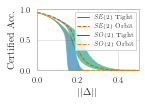

In [120]:
plot(results, 0.05, preprocess_translation=False, width=0.33, legend_fontsize=6)

In [121]:
plot(results, 0.1, preprocess_translation=False, width=0.49, legend_fontsize=7)
plt.savefig(f'/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/mnist_parallel/0.1', format='pgf')

In [122]:
plot(results, 0.15, preprocess_translation=False, width=0.49, legend_fontsize=7)
plt.savefig(f'/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/mnist_parallel/0.15', format='pgf')

In [123]:
plot(results, 0.2, preprocess_translation=False, width=0.49, legend_fontsize=7)
plt.savefig(f'/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/mnist_parallel/0.2', format='pgf')

In [124]:
plot(results, 0.25, preprocess_translation=False, width=0.49, legend_fontsize=7)
plt.savefig(f'/nfs/staff-ssd/schuchaj/pointcloud_invariance_plots/neurips_camera_ready/forward/mnist_parallel/0.25', format='pgf')